# EEG Data Analysis and Classifier

### Purpose:
This notebook shows the process of analyzing electroencephalography (EEG) data and building a neural network with the purpose of making a Brain-Computer Interface (BCI). The notebook uses a large Steady-State Visually Evoked Potential (SSVEP) dataset from the BCI Lab at the University of Tsinghua as it is the most comprehensive SSVEP dataset to date. In this notebook I load data, epoch it, graph the time series, the powerspectral density, and train neural networks.

### Dependencies:
1. matplot.lib
2. scipy
3. scikitlearn
4. pandas
5. tensorflow
6. numpy

### Table of Contents:
1. Introduction
2. Dataset Analysis 
3. Building and Training Convolutional Neural Network

## 1. Introduction

Any BCI analysis is defined by three elements: A <b>dataset</b>,
a <b>context</b>, and a <b>pipeline</b> (Jayaram et al., 2018). Once you have analyzed these three elements, you should be on the right track to creating a functional BCI.

1. A <b>dataset</b> is the quantitative data we get from an experiment. Datasets try to capture one type of EEG signal across many participants and trials. For example: motor imagery, ERP, alpha-power, and SSVEP. In our case, we will evaluate a SSVEP dataset.
2. Knowing the <b>context</b> is how we know what parameters we need to use in our pipeline. This is where the bulk of data analysis will occur. This will include data inspection for signal-noise,  periodogram graphing, artifact detection, and dimensionality reduction.
3. A <b>pipeline</b> is the algorithm that process data into labels. Remeber, our ultimate goal is to categorize SSVEP signals by labeling them. In this notebook, we will use MOABB pipelines which is based on the skikit-learn API.

SSVEP is a type of neural signal with a high signal-noise ratio. SSVEP is the most popular type of neural signal because of its functionality. Unlike moter imagery and alpha wave decoders, you can make non-binary interfaces. This means that you can have more than two keys for a given interface. With this sort of capability, SSVEP signals can allow us to create keyboards with multiple keys.



## 2. Data Inspection
The dataset consists of 64-channel Electroencephalogram (EEG) data from 35 healthy subjects (8 experienced and 27 naïve) while they performed a cue-guided target selecting task. The virtual keyboard of the speller was composed of 40 visual flickers, which were coded using a joint frequency and phase modulation (JFPM) approach. The stimulation frequencies ranged from 8 Hz to 15.8 Hz with an interval of 0.2 Hz. The phase difference between two adjacent frequencies was 0.5π. For each subject, the data included six blocks of 40 trials corresponding to all 40 flickers indicated by a visual cue in a random order. The stimulation duration in each trial was five seconds. In total, there are 210 epochs for every frequency.

### Load Subject 1 Data

In [2]:
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [147]:
'Load data'
mat = loadmat('dataset/S1.mat')
data = mat['data']

'Load labels'
freq_phase = loadmat('dataset/Freq_Phase.mat')
phases = freq_phase['phases']
freq = freq_phase['freqs']

print("Frequency labels:")
print(freq)

Frequency labels:
[[ 8.   9.  10.  11.  12.  13.  14.  15.   8.2  9.2 10.2 11.2 12.2 13.2
  14.2 15.2  8.4  9.4 10.4 11.4 12.4 13.4 14.4 15.4  8.6  9.6 10.6 11.6
  12.6 13.6 14.6 15.6  8.8  9.8 10.8 11.8 12.8 13.8 14.8 15.8]]


### Time Series

In [132]:
'Vars'
sf = 250
win = sf*5
trial = 0
epochs = 5
freq_max = 50 # We are looking for something between 8-16 HZ

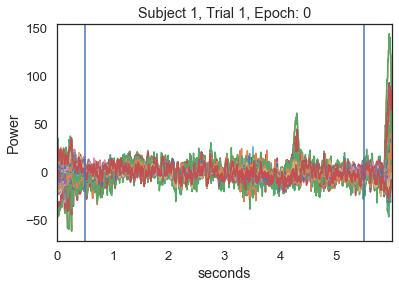

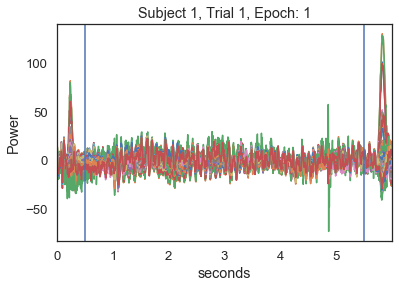

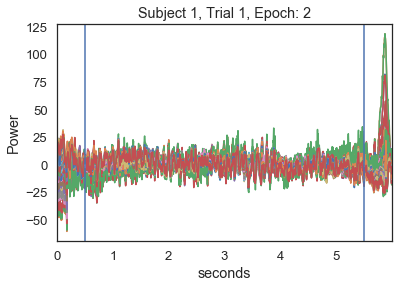

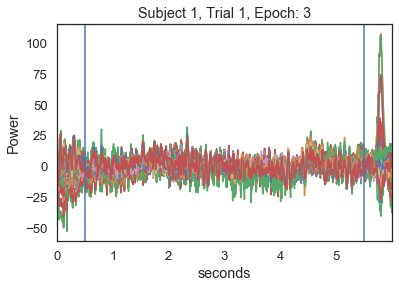

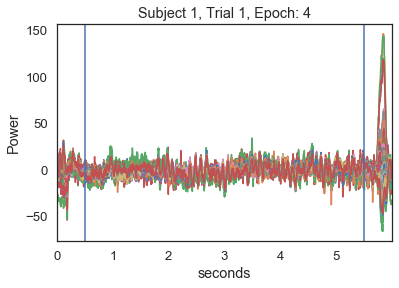

In [133]:
'Graph Time Series'
trial=0
for j in range(epochs):
    for i in range(64):
        sample = data[i,:,j,0].T # Take the first trial
        seconds = np.arange(sample.size)/sf
        sns.set(font_scale=1.2, style='white')
        plt.plot(seconds, sample)
    plt.title("Subject 1, Trial 1, Epoch: "+str(j))
    plt.xlabel('seconds')
    plt.ylabel('Power')
    plt.xlim([seconds.min(), seconds.max()])
    plt.axvline(x=0.5)
    plt.axvline(x=5.5)
    plt.show()

### Power Spectral Density

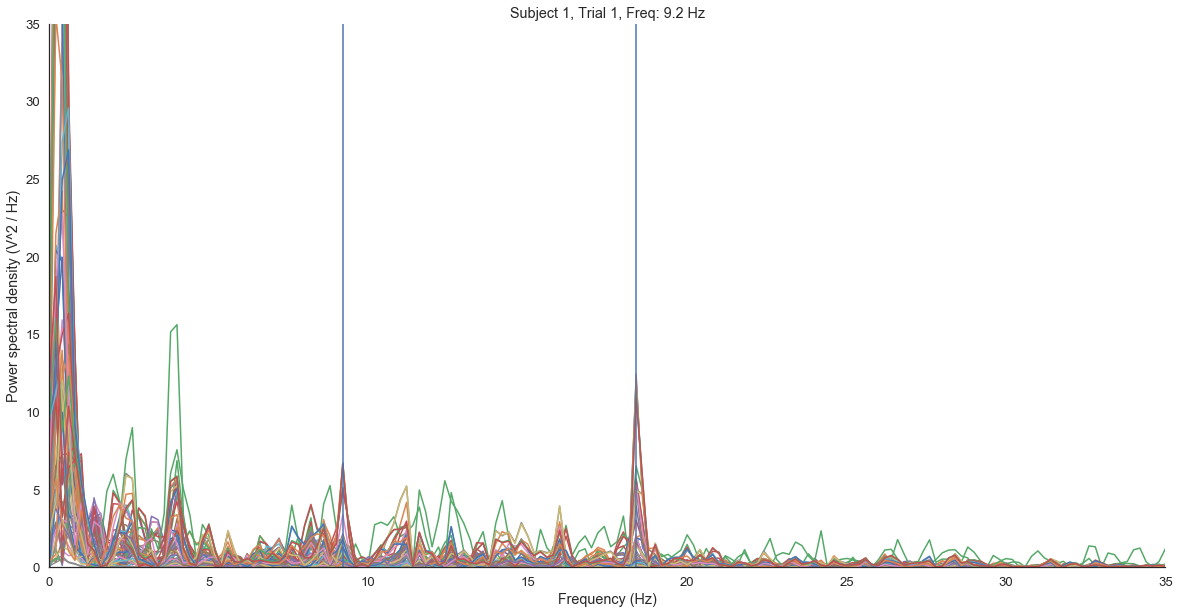

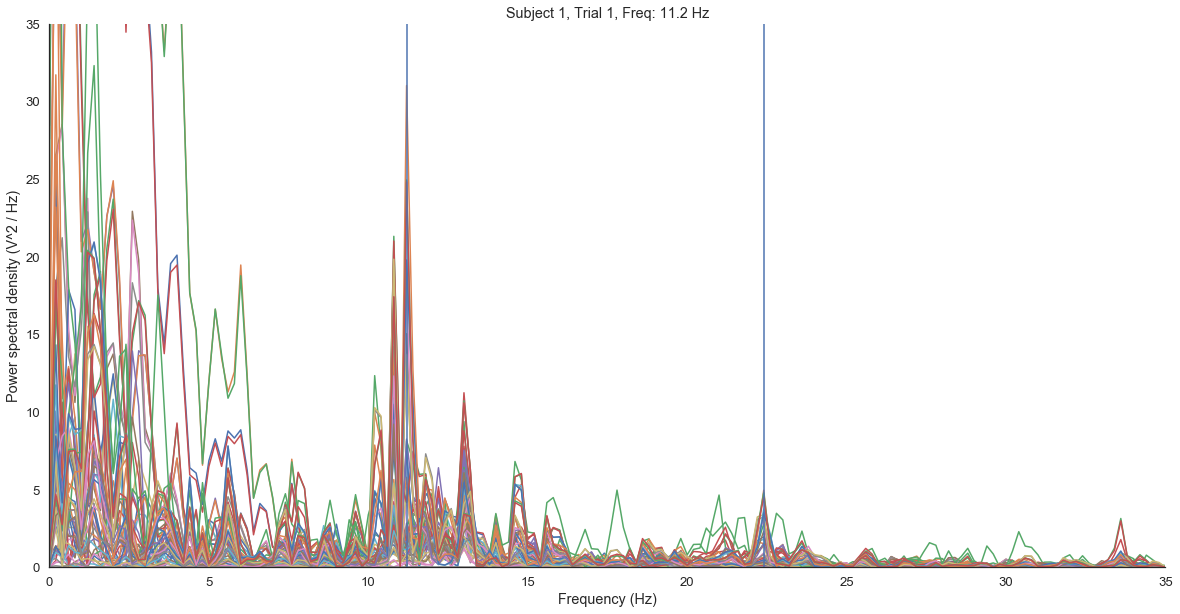

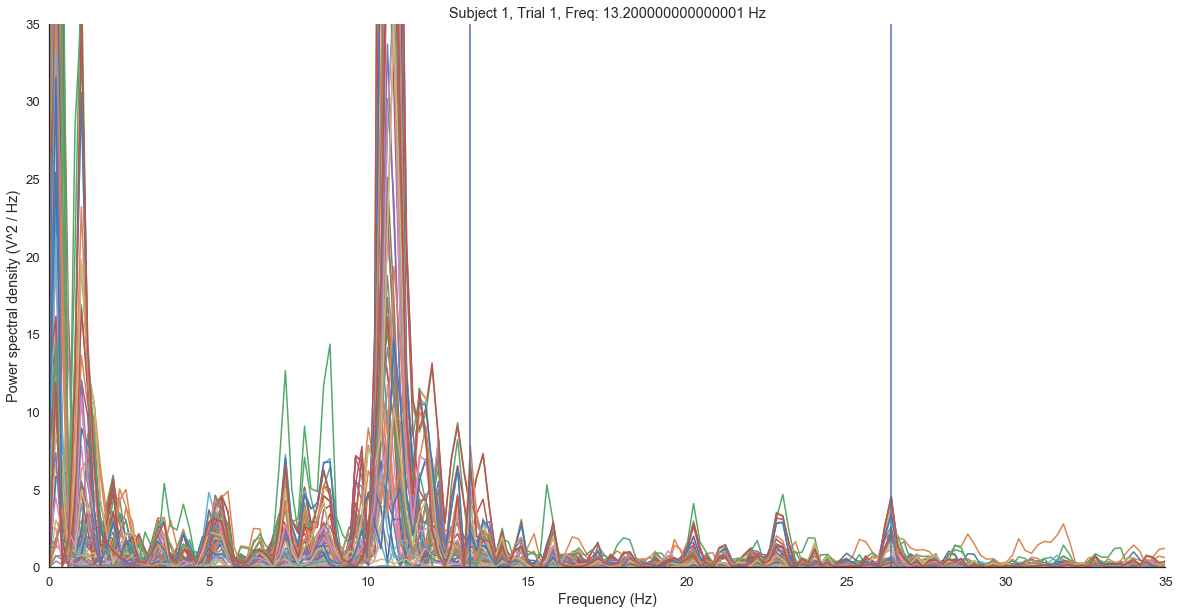

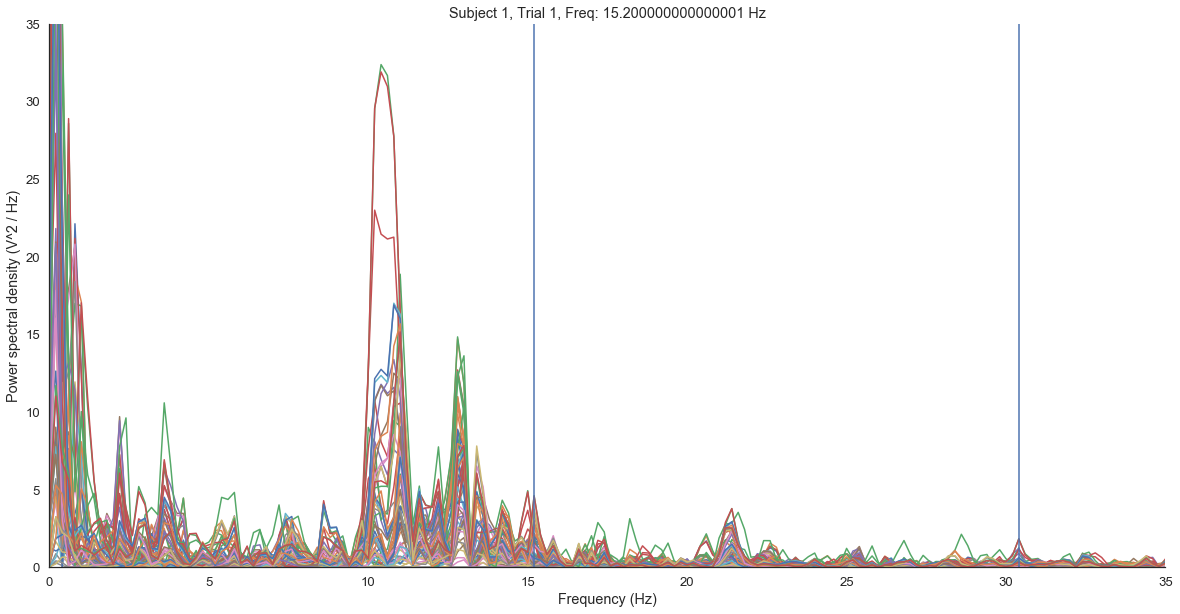

In [150]:
'Graph PSD'
epochs = [9,11,13,15]
for j in (epochs):
    plt.figure(figsize=(20,10))
    for i in range(64):
        sample = data[i,125:1375,j,trial].T # Cut off the first and last 125 samples
        freqs, psd = signal.welch(sample, fs=sf, nperseg=win)
        sns.set(font_scale=1.2, style='white')
        plt.plot(freqs,psd)   
    sns.despine()
    plt.title("Subject 1, Trial 1, Freq: "+str(freq[0,j])+str(" Hz"))
    plt.ylabel('Power spectral density (V^2 / Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylim([0, 35])
    plt.xlim([0, 35])
    plt.axvline(x=freq[0,j])
    plt.axvline(x=freq[0,j]*2)
    plt.show()

### Power Spectral Density of Electrode O1

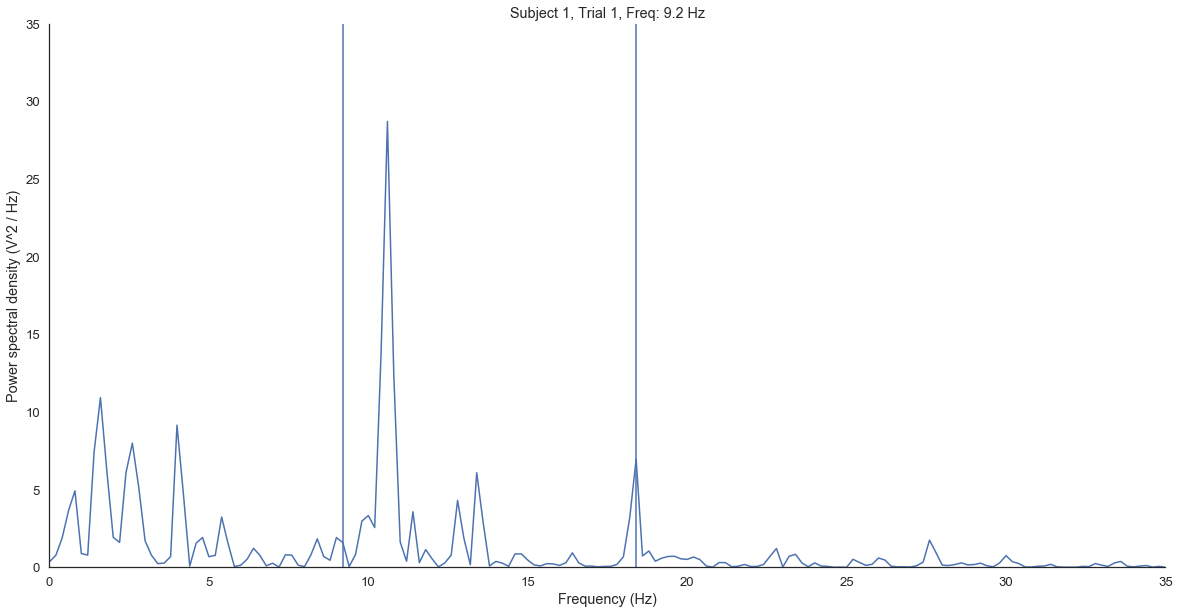

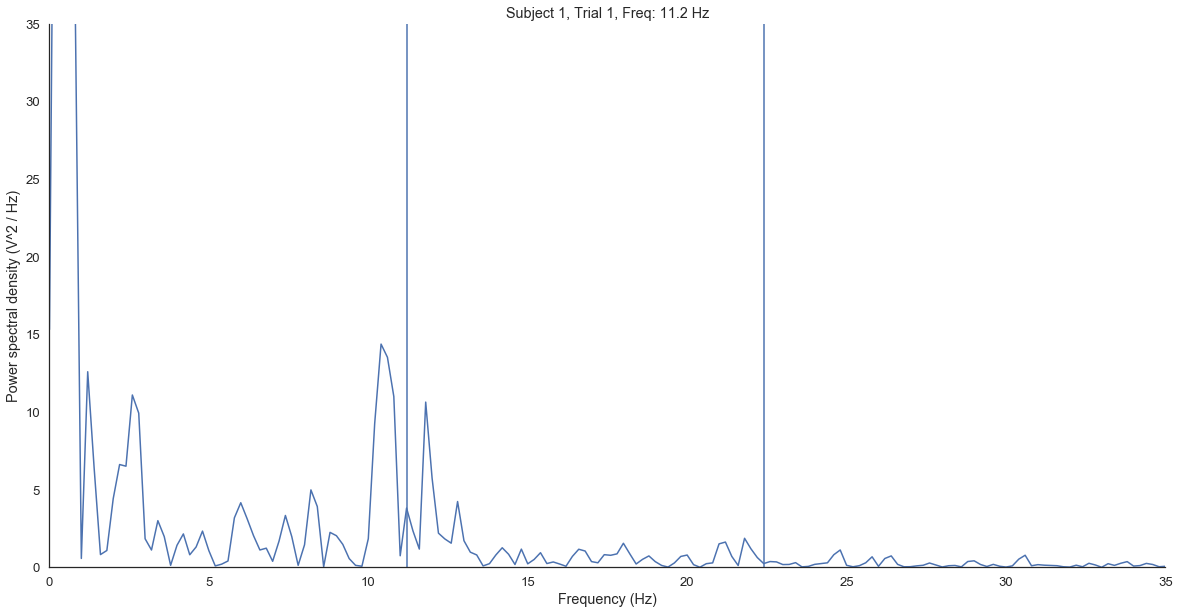

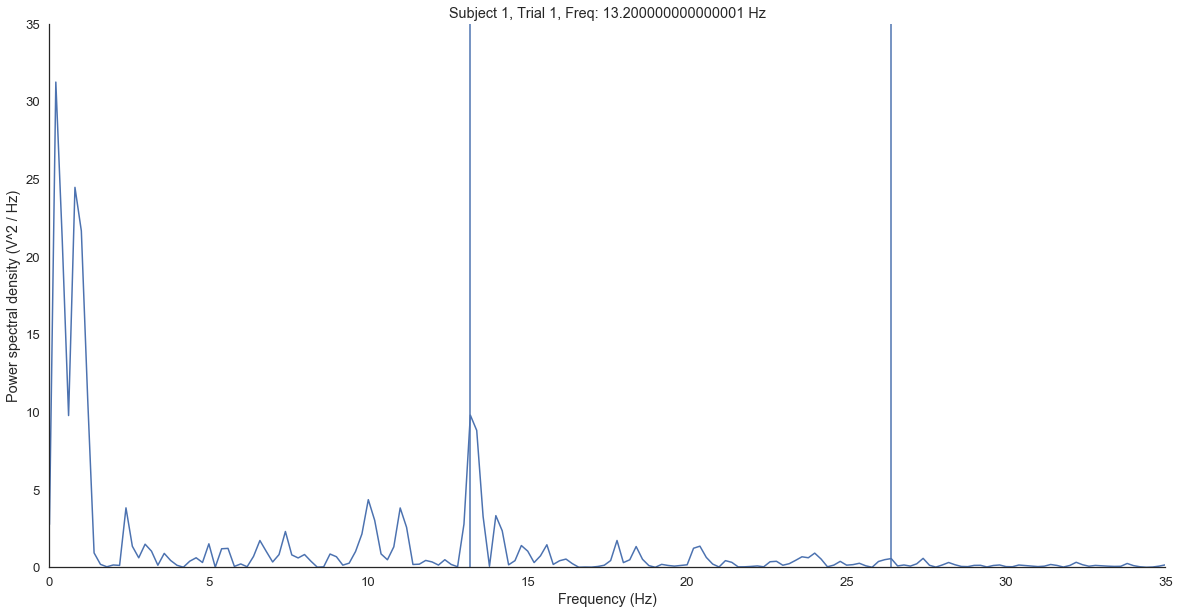

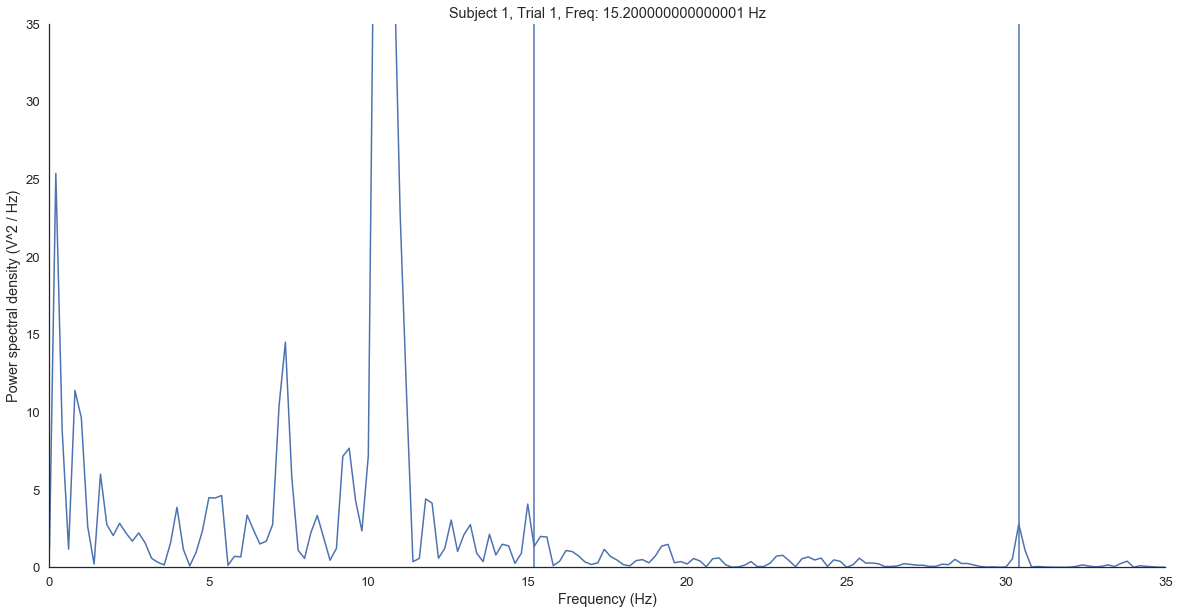

In [151]:
'Vars'
dictionary = {'O1':61,'O2':63}
channels = [60]
trial=0
epochs=40
freq_max = 50 # We are looking for something between 8-16 HZ

start = 0
end = 5
win = (end-start)*250

freq_phase = loadmat('dataset/Freq_Phase.mat')
phases = freq_phase['phases']
freqs = freq_phase['freqs']

epochs = [9,11,13,15]
'Graph 5 channels'
for j in (epochs):
    plt.figure(figsize=(20,10))
    for i in range(1):
        sample = data[channels[i],159+(250*start):159+(250*end),j,trial].T # Cut off the first and last 125 samples
        bins, psd = signal.welch(sample, fs=sf, nperseg=win)
        sns.set(font_scale=1.2, style='white')
        plt.plot(bins,psd)
    sns.despine()
    plt.title("Subject 1, Trial 1, Freq: "+str(freqs[0,j])+str(" Hz"))
    plt.ylabel('Power spectral density (V^2 / Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylim([0, 35])
    plt.xlim([0, 35])
    plt.axvline(x=freqs[0,j])
    plt.axvline(x=freqs[0,j]*2)
    plt.show()

<big>Cool, looks like you can take an educated guess as to what the frequency is by plotting the epoch's power spectral density. Now let's try to train a neural network on this data</big><br><br>

## 3. Building and Training Convolutional Neural Network

<i>Things to consider:</i>
1. Do we want to represent the data as an array of time series or PSDs?
2. What channels do we want to use?
3. Duration of stimulation we want to train the network on. We ultimately want a fast BCI, so training it on PSDs from 5 second samples means each target will take 5 seconds to hit. This will yield a very low ITR.

1. Let's try training on the PSDs
2. Let's just use Oz
3. Let's use the whole stimulus


### Reshaping Data
- We want to flatten all the data and put it into a one dimensional array of arrays
- This one dimensional array will contain (4 x 6 x 34) 816 arrays

In [155]:
'Populating data'

epochs = [1,3,5,7]
blocks = 6
subjects = 35 # One subject's data is missing
O1_index = 60

sf = 250

# 9, 11, 13, 15

x_train = np.zeros((680,626))
x_test = np.zeros((136,626))

x_train_index = 0
x_test_index = 0

for i in range(subjects):
    if i != 4: # Subject 5 is missing
        mat = loadmat('dataset/S'+str(i+1)+'.mat')
        subject = mat['data']
        for j in range(blocks):
            for k in epochs:
                sample = subject[O1_index,125:1375,k,j].T
                bins, psd = signal.welch(sample, fs=250, nperseg=sf*5)
                if (j==5):
                    x_test[x_test_index,:] = psd
                    x_test_index += 1
                else:
                    x_train[x_train_index,:] = psd
                    x_train_index += 1
            #print('Block '+str(j+1)+' done.')
        print('Subject '+str(i+1)+' done.')       

Subject 1 done.
Subject 2 done.
Subject 3 done.
Subject 4 done.
Subject 6 done.
Subject 7 done.
Subject 8 done.
Subject 9 done.
Subject 10 done.
Subject 11 done.
Subject 12 done.
Subject 13 done.
Subject 14 done.
Subject 15 done.
Subject 16 done.
Subject 17 done.
Subject 18 done.
Subject 19 done.
Subject 20 done.
Subject 21 done.
Subject 22 done.
Subject 23 done.
Subject 24 done.
Subject 25 done.
Subject 26 done.
Subject 27 done.
Subject 28 done.
Subject 29 done.
Subject 30 done.
Subject 31 done.
Subject 32 done.
Subject 33 done.
Subject 34 done.
Subject 35 done.


In [39]:
'Populating labels'

subj_trials = 6*34

freq_phase = loadmat('dataset/Freq_Phase.mat')
phases = freq_phase['phases']
freqs = freq_phase['freqs']
freqs = [9,11,13,15]

y = []
for i in range(subj_trials):
    y = np.concatenate((y, freqs), axis=None)

# There are some weird values
for i in range(816):
    y[i] = round(y[i],1)
    
index_split = int((816/6)*5)

y_train = y[:index_split]
y_test = y[index_split:]

print(y_train.shape)
print(y_test.shape)

(680,)
(136,)


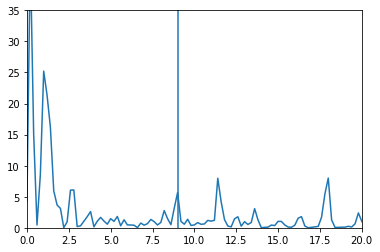

9.0


In [41]:
'Lets just make sure the data is stored properly'

# Pick a PSD to graph
epoch = 4

mat = loadmat('dataset/S1.mat')
subject = mat['data']
#sample = subject[60,125:1375,epoch,3].T # Cut off the first and last 125 samples
#freqs, psd = signal.welch(sample, fs=sf, nperseg=win)
plt.plot(bins,x_train[epoch,:])
plt.xlim([0, 20])
plt.ylim([0, 35])
plt.axvline(x=y_train[epoch])
plt.show()
print(y_train[epoch])

In [42]:
'Split data/labels for training and testing'

print('Training data shape: '+str(x_train.shape))
print('Training labels shape: '+str(y_train.shape))
print('Testing data shape: '+str(x_test.shape))
print('Testing labels shape: '+str(y_test.shape)+'\n')

x_train = np.reshape(x_train, (680, 626, 1))
x_test = np.reshape(x_test, (136, 626, 1))
print('Reshaping data for the CNN...')
print(x_train.shape)
print(x_test.shape)

Training data shape: (680, 626)
Training labels shape: (680,)
Testing data shape: (136, 626)
Testing labels shape: (136,)

Reshaping data for the CNN...
(680, 626, 1)
(136, 626, 1)


### CNN architecture

Before I began the process of constructing our own neural network, I conducted some technical validations to inspect the quality of our signals. I started by analyzing the amplitude spectrum of every trial from the first block of the first participant. This was accomplished by computing each epoch’s Fourier transformations using Welch’s method and then plotted the amplitude spectrum. Amplitude peaks in microvolts were observed for the SSVEP frequencies. I also observed that there were amplitude peaks in the alpha wave frequency range. Alpha waves are oscillations in the range of 8-12Hz, and is the most common wave found in wakeful relaxation. Some of the amplitude peaks for the alpha waves are strong enough to compete with the SSVEP signals which are within the 8-15.8Hz range. I also observed amplitude peaks for the higher harmonic components of the SSVEP frequencies, specifically for the second, third, and fourth harmonic. The range of these frequencies are within the 16-63.2 Hz. There is significantly less noise in this range. The harmonic components should be useful for detecting SSVEPs because in the absence of a clear amplitude peak for the fundamental component, the harmonic components should be quite clear. Finally, I only used the Oz channel, as I observed that it contributed the most to the SSVEP signal and the other channels would only add redundancy.

I used four convolutional layers with ReLU activation functions with max pooling layers in between each later. Finally I used four dense layers at the end, all with ReLU activation functions. I trained the neural network on the spectral data. I achieved a maximum of 86.8% accuracy when the output value was within 1Hz.

In [108]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

print(tf.__version__)
print(keras.__version__)

2.3.1
2.4.0


In [109]:
model = models.Sequential()
model.add(layers.Convolution1D(5, 9, activation='relu', input_shape=(626,1)))

model.add(layers.MaxPooling1D(2)) # Will half the convolution. Take the larger of the two. Keep halfing until you get to 20, Until time series is small
model.add(layers.Conv1D(3, 9, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(2, 9, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(1, 9, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten()) # Flatten the data to put in 1D
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='relu'))

model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 618, 5)            50        
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 309, 5)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 301, 3)            138       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 150, 3)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 142, 2)            56        
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 71, 2)             0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 63, 1)            

### Training and Testing

In [111]:
#Training
model.fit(x_train, y_train, epochs=400, batch_size=32, verbose=1)
#Testing
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)

Epoch 1/400
22/22 [==============================] - 0s 12ms/step - loss: 0.4748
Epoch 2/400
22/22 [==============================] - 0s 11ms/step - loss: 0.4634
Epoch 3/400
22/22 [==============================] - 0s 11ms/step - loss: 0.4835
Epoch 4/400
22/22 [==============================] - 0s 11ms/step - loss: 0.4588
Epoch 5/400
22/22 [==============================] - 0s 11ms/step - loss: 0.4974
Epoch 6/400
22/22 [==============================] - 0s 11ms/step - loss: 0.5044
Epoch 7/400
22/22 [==============================] - 0s 11ms/step - loss: 0.4844
Epoch 8/400
22/22 [==============================] - 0s 11ms/step - loss: 0.4860
Epoch 9/400
22/22 [==============================] - 0s 11ms/step - loss: 0.5219
Epoch 10/400
22/22 [==============================] - 0s 11ms/step - loss: 0.4542
Epoch 11/400
22/22 [==============================] - 0s 11ms/step - loss: 0.4468
Epoch 12/400
22/22 [==============================] - 0s 11ms/step - loss: 0.4559
Epoch 13/400
22/22 [=====

22/22 [==============================] - 0s 12ms/step - loss: 0.3372
Epoch 102/400
22/22 [==============================] - 0s 11ms/step - loss: 0.3344
Epoch 103/400
22/22 [==============================] - 0s 11ms/step - loss: 0.3547
Epoch 104/400
22/22 [==============================] - 0s 12ms/step - loss: 0.3880
Epoch 105/400
22/22 [==============================] - 0s 11ms/step - loss: 0.4044
Epoch 106/400
22/22 [==============================] - 0s 11ms/step - loss: 0.3218
Epoch 107/400
22/22 [==============================] - 0s 12ms/step - loss: 0.3421
Epoch 108/400
22/22 [==============================] - 0s 10ms/step - loss: 0.3162
Epoch 109/400
22/22 [==============================] - 0s 10ms/step - loss: 0.3439
Epoch 110/400
22/22 [==============================] - 0s 13ms/step - loss: 0.4254
Epoch 111/400
22/22 [==============================] - 0s 11ms/step - loss: 0.4248
Epoch 112/400
22/22 [==============================] - 0s 12ms/step - loss: 0.3595
Epoch 113/400
22/2

22/22 [==============================] - 0s 10ms/step - loss: 0.2409
Epoch 201/400
22/22 [==============================] - 0s 9ms/step - loss: 0.2619
Epoch 202/400
22/22 [==============================] - 0s 10ms/step - loss: 0.2643
Epoch 203/400
22/22 [==============================] - 0s 10ms/step - loss: 0.2456
Epoch 204/400
22/22 [==============================] - 0s 9ms/step - loss: 0.2566
Epoch 205/400
22/22 [==============================] - 0s 10ms/step - loss: 0.2739
Epoch 206/400
22/22 [==============================] - 0s 10ms/step - loss: 0.3316
Epoch 207/400
22/22 [==============================] - 0s 9ms/step - loss: 0.2638
Epoch 208/400
22/22 [==============================] - 0s 10ms/step - loss: 0.2982
Epoch 209/400
22/22 [==============================] - 0s 10ms/step - loss: 0.2500
Epoch 210/400
22/22 [==============================] - 0s 10ms/step - loss: 0.2631
Epoch 211/400
22/22 [==============================] - 0s 9ms/step - loss: 0.2827
Epoch 212/400
22/22 [=

22/22 [==============================] - 0s 10ms/step - loss: 0.1828
Epoch 300/400
22/22 [==============================] - 0s 9ms/step - loss: 0.1791
Epoch 301/400
22/22 [==============================] - 0s 10ms/step - loss: 0.2195
Epoch 302/400
22/22 [==============================] - 0s 10ms/step - loss: 0.2124
Epoch 303/400
22/22 [==============================] - 0s 10ms/step - loss: 0.1842
Epoch 304/400
22/22 [==============================] - 0s 10ms/step - loss: 0.1714
Epoch 305/400
22/22 [==============================] - 0s 10ms/step - loss: 0.1845
Epoch 306/400
22/22 [==============================] - 0s 9ms/step - loss: 0.1978
Epoch 307/400
22/22 [==============================] - 0s 11ms/step - loss: 0.1991
Epoch 308/400
22/22 [==============================] - 0s 9ms/step - loss: 0.2155
Epoch 309/400
22/22 [==============================] - 0s 9ms/step - loss: 0.2137
Epoch 310/400
22/22 [==============================] - 0s 10ms/step - loss: 0.1960
Epoch 311/400
22/22 [=

22/22 [==============================] - 0s 13ms/step - loss: 0.1604
Epoch 399/400
22/22 [==============================] - 0s 12ms/step - loss: 0.1704
Epoch 400/400
22/22 [==============================] - 0s 12ms/step - loss: 0.1473
Test loss: 3.947794198989868


In [90]:
score = model.evaluate(x_test, y_test, verbose = 0)
print(score)

2.619950294494629


Run 1: 2.002

Run 2: 1.842

Actual frequency: 15.0
Predicted frequency: 15.072884559631348


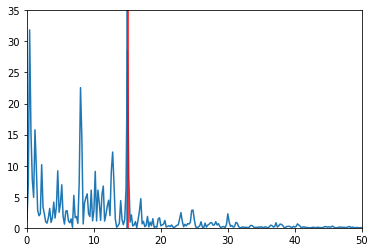

Accuracy: 0.8676470588235294


In [120]:
epoch_index = 7
prediction = model.predict(np.array([x_test[epoch_index,:,:],]))
print('Actual frequency: '+str(y_test[epoch_index]))
print('Predicted frequency: '+str(float(prediction)))

plt.plot(bins,x_test[epoch_index,:])
plt.xlim([0, 50])
plt.ylim([0, 35])
plt.axvline(x=y_test[epoch_index])
plt.axvline(x=prediction, color = 'r')
plt.show()

error=0
acc=0

for i in range(136):
    prediction = model.predict(np.array([x_test[i,:,:],]))
    actual = y_test[i]
    error += abs(prediction-actual)
    #print(prediction-actual)
    if((prediction-actual)<=1):
        acc += 1
        
#print("Mean test error: "+str(error/136))
print("Accuracy: "+str(acc/136))
